In [1]:
import os
import numpy as np
import pandas as pd
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import faiss

import sys
sys.path.append(os.path.expandvars('$WORK/dream-domain/code/dream-ood-main'))
from scripts.resnet import ResNet_Model
from scripts.KNN import generate_outliers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Prepare data

In [2]:
traindir = os.path.expandvars('$WORK/DATA/IN100/train')
valdir = os.path.expandvars('$WORK/DATA/IN100/val')

train_data = torchvision.datasets.ImageFolder(
    traindir,
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ]))

test_data = torchvision.datasets.ImageFolder(
    valdir,
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ]))
num_classes = 100

# Set batch size
batch_size = 128

# Create dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## t-SNE

features computed


/tmp/ipykernel_781661/2282850915.py:34: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
/tmp/ipykernel_781661/2282850915.py:37: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(features_2d[labels == c, 0], features_2d[labels == c, 1], c=cmap(c), s=3, alpha=0.5)


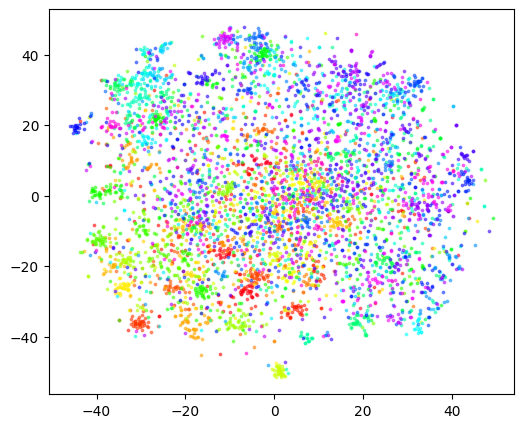

In [3]:
# Load classifier

classifier = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)
classifier = classifier.to(device)

state_dict = torch.load('../results/classifier/resnet50_in100_epoch_9.pth')
classifier.load_state_dict(state_dict)

# Define a new model that is the same as the original model but without the final layer
classifier_feature_extractor = torch.nn.Sequential(*list(classifier.children())[:-1])

features_list = []
labels_list = []

# Pass the test data through the new model to get the features
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = classifier_feature_extractor(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())

features = np.concatenate(features_list)
labels = np.concatenate(labels_list)

print('features computed')

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features.squeeze())

# Plot the results
cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
plt.figure(figsize=(6, 5))
for c in range(num_classes):
    plt.scatter(features_2d[labels == c, 0], features_2d[labels == c, 1], c=cmap(c), s=3, alpha=0.5)
plt.show()

features computed


/tmp/ipykernel_781661/729410867.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
/tmp/ipykernel_781661/729410867.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(features_2d[:-anchor.shape[0]][labels == c, 0], features_2d[:-anchor.shape[0]][labels == c, 1], c=cmap(c), s=3, alpha=0.5)


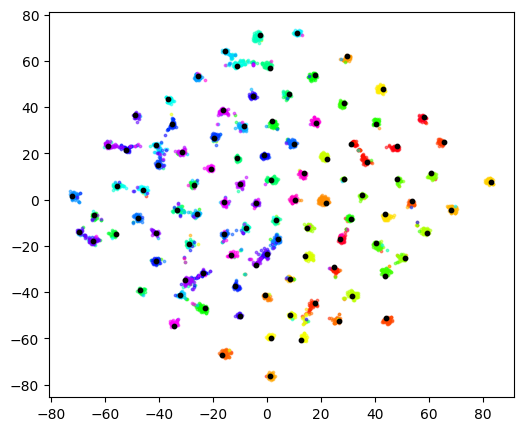

In [4]:
# Load the anchor embeddings
anchor = np.load('dream-ood-main/token_embed_in100.npy')

# Load encoder

encoder = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
encoder.fc = nn.Linear(encoder.fc.in_features, 768)
encoder = encoder.to(device)

state_dict = torch.load('../results/encoder/resnet50_in100_epoch_9.pth')
encoder.load_state_dict(state_dict)

features_list = []
labels_list = []

# Pass the test data through the new model to get the features
with torch.no_grad():
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = encoder(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        if len(features_list) > 40:
            break

features = np.concatenate(features_list)
features = np.concatenate((features, anchor))
features = torch.nn.functional.normalize(torch.tensor(features), p=2, dim=-1).numpy()
labels = np.concatenate(labels_list)

print('features computed')

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
plt.figure(figsize=(6, 5))
for c in range(num_classes):
    plt.scatter(features_2d[:-anchor.shape[0]][labels == c, 0], features_2d[:-anchor.shape[0]][labels == c, 1], c=cmap(c), s=3, alpha=0.5)
plt.scatter(features_2d[-anchor.shape[0]:, 0], features_2d[-anchor.shape[0]:, 1], c='k', s=10)
plt.show()

features computed


/tmp/ipykernel_781661/949029299.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
/tmp/ipykernel_781661/949029299.py:41: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(features_2d[:-anchor.shape[0]][labels == c, 0], features_2d[:-anchor.shape[0]][labels == c, 1], c=cmap(c), s=3, alpha=0.5)


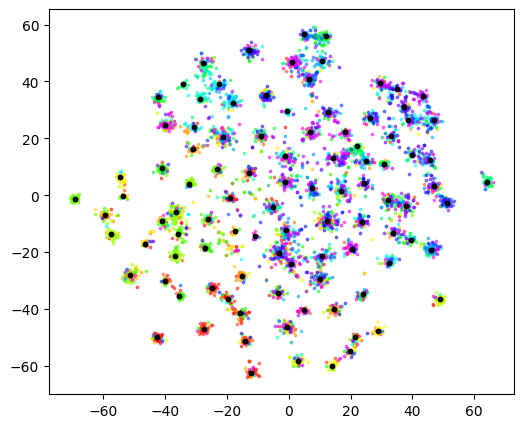

In [5]:
# Load the anchor embeddings
anchor = np.load('dream-ood-main/token_embed_in100.npy')

# Load encoder

encoder = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
encoder.fc = nn.Linear(encoder.fc.in_features, 768)
encoder = encoder.to(device)

state_dict = torch.load('../results/encoder/resnet50_in100_epoch_9.pth')
encoder.load_state_dict(state_dict)

features_list = []
labels_list = []

# Pass the test data through the new model to get the features
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        features = encoder(images)
        features_list.append(features.cpu().numpy())
        labels_list.append(labels.cpu().numpy())
        if len(features_list) > 40:
            break

features = np.concatenate(features_list)
features = np.concatenate((features, anchor))
features = torch.nn.functional.normalize(torch.tensor(features), p=2, dim=-1).numpy()
labels = np.concatenate(labels_list)

print('features computed')

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
cmap = plt.cm.get_cmap('gist_rainbow', num_classes)  # 'gist_rainbow' is a colormap with many distinct colors
plt.figure(figsize=(6, 5))
for c in range(num_classes):
    plt.scatter(features_2d[:-anchor.shape[0]][labels == c, 0], features_2d[:-anchor.shape[0]][labels == c, 1], c=cmap(c), s=3, alpha=0.5)
plt.scatter(features_2d[-anchor.shape[0]:, 0], features_2d[-anchor.shape[0]:, 1], c='k', s=10)
plt.show()

## tSNE embeddings

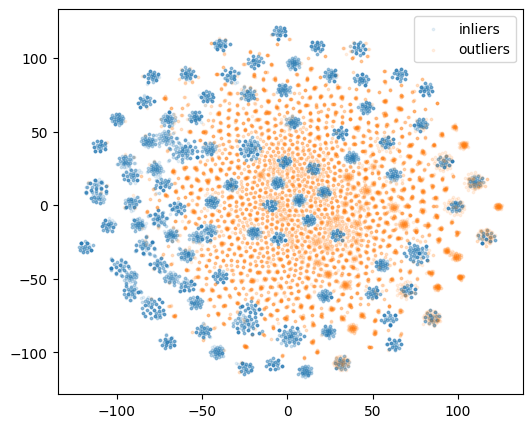

In [6]:
inliers = np.load('../results/embeddings/inlier_npos_embed_noise_0.01_select_1000_KNN_300.npy')
outliers = np.load('../results/embeddings/outlier_npos_embed_noise_0.03_select_200_KNN_300.npy')

chosen_class = 0
inliers = inliers[chosen_class]
outliers = outliers[chosen_class]

features = np.concatenate((inliers, outliers))

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(features_2d[:inliers.shape[0], 0], features_2d[:inliers.shape[0], 1], c='C0', s=3, alpha=0.1, label='inliers')
plt.scatter(features_2d[inliers.shape[0]:, 0], features_2d[inliers.shape[0]:, 1], c='C1', s=3, alpha=0.1, label='outliers')
plt.legend()
plt.show()

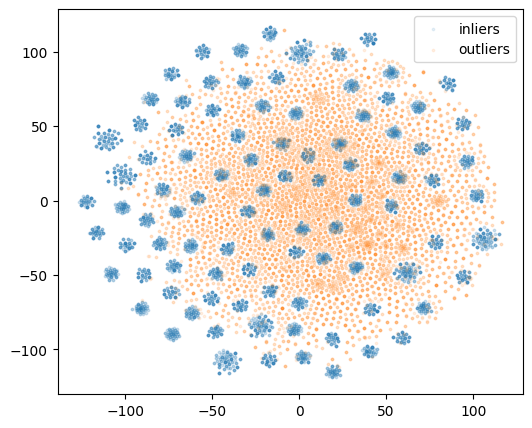

In [7]:
inliers = np.load('../results/embeddings/shift_npos_embed.npy')
outliers = np.load('../results/embeddings/outlier_npos_embed.npy')

chosen_class = 1
inliers = inliers[chosen_class]
outliers = outliers[chosen_class]

features = np.concatenate((inliers, outliers))

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(features_2d[:inliers.shape[0], 0], features_2d[:inliers.shape[0], 1], c='C0', s=3, alpha=0.1, label='inliers')
plt.scatter(features_2d[inliers.shape[0]:, 0], features_2d[inliers.shape[0]:, 1], c='C1', s=3, alpha=0.1, label='outliers')
plt.legend()
plt.show()

# Test encoder trained with classifier failures

In [ ]:
df_res_standard = pd.read_csv('../results/encoder_custom_standard_long/evaluation.csv')
df_res_custom = pd.read_csv('../results/encoder_custom/evaluation.csv')
df_res_custom_1 = pd.read_csv('../results/encoder_custom_1/evaluation.csv')
df_res_custom_2 = pd.read_csv('../results/encoder_custom_2/evaluation.csv')
df_res_custom_2bis = pd.read_csv('../results/encoder_custom_2bis/evaluation.csv')

dict_df = {
    'standard': df_res_standard,
    # 'custom': df_res_custom,- # BAD
    # 'custom1': df_res_custom_1, # PROMISING
    # 'custom2': df_res_custom_2, # VERY BAD
    'custom2bis': df_res_custom_2bis, # PROMISING
}

dataloader = 'test'
for key, df in dict_df.items():
    dict_df[key] = df[df['dataloader'] == dataloader]
# df_res_standard = df_res_standard[df_res_standard['dataloader'] == dataloader]
# df_res_custom = df_res_custom[df_res_custom['dataloader'] == dataloader]
# df_res_custom_1 = df_res_custom_1[df_res_custom_1['dataloader'] == dataloader]

plt.figure()
for encoder, df in dict_df.items():
    for i, metric in enumerate(['auroc_encoder_true', 'auroc_encoder_max', 'auroc_encoder_pred']):
        plt.plot(df['epoch'], df[metric], label=f'{encoder} {metric}', color=f'C{i}', ls='-' if 'standard' in encoder else '--')
plt.plot(df['epoch'], df['auroc_classif'], color='k', ls=':', label='auroc_classif')
plt.legend()
plt.xlabel('encoder epoch')
plt.ylabel('AUROC')

In [ ]:
inliers = np.load('../results/embeddings/inlier_npos_embed_noise_0.01_select_1000_KNN_300.npy')
outliers = np.load('../results/embeddings/outlier_npos_embed_noise_0.03_select_200_KNN_300.npy')

# chosen_class = 0
# inliers = inliers[chosen_class]
# outliers = outliers[chosen_class]

# Reproduce tsne paper: need ID_points_num=2 and pic_nums=50 for both outliers and inliers. but why?

In [ ]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import faiss
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt



sys.path.append(os.path.expandvars('$WORK/dream-domain/code/dream-ood-main'))
from scripts.KNN import generate_outliers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 2

anchor = torch.from_numpy(np.load('dream-ood-main/token_embed_in100.npy'))
id_features = torch.tensor(np.load('../results/encoder/id_feat_in100.npy')).cuda()
ID = nn.functional.normalize(id_features, p=2, dim=2)
K_in_knn = 300
gaussian_mag_ood_det = 0.03
gaussian_mag_ood_gene = 0.01
ood_gene_select = 1000
ood_det_select = 200
res = faiss.StandardGpuResources()
KNN_index = faiss.GpuIndexFlatL2(res, 768)
new_dis = torch.distributions.MultivariateNormal(torch.zeros(768).cuda(), torch.eye(768).cuda())
negative_samples = new_dis.rsample((1500,))

for c in range(num_classes):
    print(c)

    ID_class = ID[c]
    for index in range(100):
        sample_point, boundary_point = generate_outliers(ID_class,
                                                        input_index=KNN_index,
                                                        negative_samples=negative_samples,
                                                        ID_points_num=2,
                                                        K=K_in_knn,
                                                        select=ood_gene_select,
                                                        cov_mat=gaussian_mag_ood_gene,
                                                        sampling_ratio=1.0,
                                                        pic_nums=50,
                                                        depth=768, 
                                                        shift=1)

        sample_point_in = torch.cat([sample_point_in, sample_point], 0) if index > 0 else sample_point
            
    for index in range(100):
        sample_point, boundary_point = generate_outliers(ID_class,
                                                            input_index=KNN_index,
                                                            negative_samples=negative_samples,
                                                            ID_points_num=2,
                                                            K=K_in_knn,
                                                            select=ood_det_select,
                                                            cov_mat=gaussian_mag_ood_det, 
                                                            sampling_ratio=1.0, 
                                                            pic_nums=50,
                                                            depth=768,
                                                            shift=0)
        sample_point_out = torch.cat([sample_point_out, sample_point], 0) if index > 0 else sample_point


    if c == 0:
        inliers_samples = [sample_point_in * anchor[index].norm()]
        outliers_samples = [sample_point_out * anchor[index].norm()]
    else:
        inliers_samples.append(sample_point_in * anchor[index].norm())
        outliers_samples.append(sample_point_out * anchor[index].norm())

c = 1
inliers = torch.stack(inliers_samples)[c]
outliers = torch.stack(outliers_samples)[c]
features = torch.cat((inliers, outliers))

features = torch.nn.functional.normalize(features, p=2, dim=1)
features = features.cpu().data.numpy()

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(features_2d[:inliers.shape[0], 0], features_2d[:inliers.shape[0], 1], c='C0', s=3, alpha=0.1, label='inliers')
plt.scatter(features_2d[inliers.shape[0]:, 0], features_2d[inliers.shape[0]:, 1], c='C1', s=3, alpha=0.1, label='outliers')
plt.legend()
plt.show()

In [ ]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import faiss
import torch.nn.functional as F

sys.path.append(os.path.expandvars('$WORK/dream-domain/code/dream-ood-main'))
from scripts.KNN import generate_outliers

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 3

anchor = torch.from_numpy(np.load('dream-ood-main/token_embed_in100.npy'))
id_features = torch.tensor(np.load('../results/encoder/id_feat_in100.npy')).cuda()
ID = nn.functional.normalize(id_features, p=2, dim=2)
K_in_knn = 300
gaussian_mag_ood_det = 0.03
gaussian_mag_ood_gene = 0.01
ood_gene_select = 1000
ood_det_select = 200
res = faiss.StandardGpuResources()
KNN_index = faiss.GpuIndexFlatL2(res, 768)
new_dis = torch.distributions.MultivariateNormal(torch.zeros(768).cuda(), torch.eye(768).cuda())

def KNN_dis_search_decrease(target, index, K=50, select=1,shift=0):
    '''
    data_point: Queue for searching k-th points
    target: the target of the search
    K
    '''
    #Normalize the features

    target_norm = torch.norm(target, p=2, dim=1,  keepdim=True)
    normed_target = target / target_norm
    #start_time = time.time()

    distance, output_index = index.search(normed_target, K)
    k_th_distance = distance[:, -1]
    #k_th_output_index = output_index[:, -1]
    if shift:
        k_th_distance, minD_idx = torch.topk(-k_th_distance, select)
    else:
        k_th_distance, minD_idx = torch.topk(k_th_distance, select)
    #k_th_index = k_th_output_index[minD_idx]
    return minD_idx, k_th_distance

def KNN_dis_search_distance(target, index, K=50, num_points=10, length=2000,depth=342,shift=0):
    '''
    data_point: Queue for searching k-th points
    target: the target of the search
    K
    '''
    #Normalize the features

    target_norm = torch.norm(target, p=2, dim=1,  keepdim=True)
    normed_target = target / target_norm
    #start_time = time.time()

    distance, output_index = index.search(normed_target, K)
    k_th_distance = distance[:, -1]
    k_th = k_th_distance.view(length, -1)
    target_new = target.view(length, -1, depth)
    #k_th_output_index = output_index[:, -1]
    if shift:
        k_th_distance, minD_idx = torch.topk(-k_th, num_points, dim=0)
    else:
        k_th_distance, minD_idx = torch.topk(k_th, num_points, dim=0)
    print(minD_idx.shape)
    minD_idx = minD_idx.squeeze()
    point_list = []
    # breakpoint()
    if len(minD_idx.size()) == 1:
        minD_idx = minD_idx.reshape(-1,1)
    for i in range(minD_idx.shape[1]):
        point_list.append(i*length + minD_idx[:,i])
    #return tor+ch.cat(point_list, dim=0)

    return target[torch.cat(point_list)]

In [ ]:
ID_class = ID[1]
negative_samples = new_dis.rsample((1500,))

input_index=KNN_index
ID_points_num=1
K=K_in_knn
select=ood_gene_select
cov_mat=gaussian_mag_ood_gene
sampling_ratio=1.0
pic_nums=100
depth=768
shift=1

# input_index=KNN_index
# ID_points_num=2
# K=K_in_knn
# select=ood_det_select
# cov_mat=gaussian_mag_ood_det
# sampling_ratio=1.0
# pic_nums=50
# depth=768
# shift=0

length = negative_samples.shape[0]
data_norm = torch.norm(ID_class, p=2, dim=1, keepdim=True)
normed_data = ID_class / data_norm
rand_ind = np.random.choice(normed_data.shape[0], int(normed_data.shape[0] * sampling_ratio), replace=False)
index = input_index
index.add(normed_data[rand_ind])
minD_idx, k_th = KNN_dis_search_decrease(ID_class, index, K, select, shift=shift)
boundary_data = ID_class[minD_idx]
# # breakpoint()
minD_idx = minD_idx[np.random.choice(select, int(pic_nums), replace=False)]
data_point_list = torch.cat([ID_class[i:i+1].repeat(length,1) for i in minD_idx])
negative_sample_cov = cov_mat * negative_samples.cuda().repeat(pic_nums,1)
negative_sample_list = F.normalize(negative_sample_cov + data_point_list, p=2, dim=1)
# # breakpoint()
point = KNN_dis_search_distance(negative_sample_list, index, K, ID_points_num, length,depth, shift=shift)
point.shape
# index.reset()

In [ ]:
inliers_samples

In [ ]:
inliers = np.load('../results/embeddings/shift_npos_embed.npy')
outliers = np.load('../results/embeddings/outlier_npos_embed.npy')

chosen_class = 1
inliers = inliers[chosen_class]
outliers = outliers[chosen_class]

features = np.concatenate((inliers, outliers))

# Apply t-SNE to the features
tsne = TSNE(n_components=2, random_state=0)
features_2d = tsne.fit_transform(features)

# Plot the results
plt.figure(figsize=(6, 5))
plt.scatter(features_2d[:inliers.shape[0], 0], features_2d[:inliers.shape[0], 1], c='C0', s=3, alpha=0.1, label='inliers')
plt.scatter(features_2d[inliers.shape[0]:, 0], features_2d[inliers.shape[0]:, 1], c='C1', s=3, alpha=0.1, label='outliers')
plt.legend()
plt.show()

# RnC loss

In [8]:
import os
import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.models import resnet50, ResNet50_Weights

from rnc_loss import RnCLoss


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# PREPARE DATA

traindir = os.path.expandvars('$WORK/DATA/IN100/train')
valdir = os.path.expandvars('$WORK/DATA/IN100/val')

train_data = torchvision.datasets.ImageFolder(
    traindir,
    torchvision.transforms.Compose([
        torchvision.transforms.RandomResizedCrop(224),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ]))

test_data = torchvision.datasets.ImageFolder(
    valdir,
    torchvision.transforms.Compose([
        torchvision.transforms.Resize(256),
        torchvision.transforms.CenterCrop(224),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225]),
    ]))
num_classes = 100

# Set batch size
batch_size = 128

# Create dataloaders
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# LOAD CLASSIFIER

# Create the classifier
classifier = resnet50(weights=ResNet50_Weights.DEFAULT)
classifier.fc = nn.Linear(classifier.fc.in_features, num_classes)
classifier = classifier.to(device)

# Load
state_dict = torch.load('../results/classifier/resnet50_in100_epoch_9.pth')
classifier.load_state_dict(state_dict)
classifier.eval()
classifier_feature_extractor = torch.nn.Sequential(*(list(classifier.children())[:-1]))

# TRAIN ENCODER

# # Load the anchor embeddings
# anchor = torch.from_numpy(np.load('dream-ood-main/token_embed_in100.npy')).cuda()

# # Create the encoder
# encoder = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
# # encoder = torchvision.models.resnet50()
# encoder.fc = nn.Linear(encoder.fc.in_features, 768)
# encoder = encoder.to(device)

class MLPEncoder(nn.Module):
    def __init__(self, input_size, embedding_size):
        super(MLPEncoder, self).__init__()
        # Define the architecture
        self.fc1 = nn.Linear(input_size, 512)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(512, embedding_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
encoder = MLPEncoder(100, 1).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
rnc = RnCLoss()
optimizer = optim.SGD(encoder.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

# Define the number of epochs
num_epochs = 20

# Training loop
for epoch in range(num_epochs):
    loss_avg = 0.0
    true_classe_cosim_correct_avg = 0.0
    true_classe_cosim_incorrect_avg = 0.0
    
    # Set the encoder to training mode
    encoder.train()
    
    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass through the frozen classifier
        with torch.no_grad():
            classif_features = classifier_feature_extractor(images)
            classif_outputs = classifier(images)
            probas = torch.softmax(classif_outputs, 1)
            confidences, predicted = torch.max(probas, 1)
            incorrect = (predicted != labels)

        # Forward pass
        features = encoder(probas)

        # # Cosine similarity
        # outputs = torch.nn.functional.cosine_similarity(anchor.unsqueeze(0).repeat(features.shape[0], 1, 1), 
        #                                                 features.unsqueeze(1).repeat(1, num_classes, 1), 2) / 0.1
        
        # # Compute the loss
        # loss = criterion(outputs, labels)
        loss_rnc = rnc(features, confidences.unsqueeze(1), double_view=False)
        print(f'loss RnC {loss_rnc:.3f}')
        loss = loss_rnc
        

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
    #     # Update statistics
    #     loss_avg = loss_avg * 0.8 + loss.item() * 0.2
    #     true_classe_cosim = 0.1 * outputs[torch.arange(outputs.shape[0]), labels].detach()
    #     true_classe_cosim_correct_avg = true_classe_cosim_correct_avg * 0.8 + true_classe_cosim[incorrect.bitwise_not()].mean().item() * 0.2
    #     if incorrect.any():
    #         true_classe_cosim_incorrect_avg = true_classe_cosim_incorrect_avg * 0.8 + true_classe_cosim[incorrect].mean().item() * 0.2
    
    # # Print the statistics for each epoch
    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss_avg:.3f}, True class cosine similarity (correct): {true_classe_cosim_correct_avg:.3f}, True class cosine similarity (incorrect): {true_classe_cosim_incorrect_avg:.3f}")

    
    # Save the model after each epoch
    torch.save(encoder.state_dict(), f"../results/encoder_RnC/resnet50_in100_epoch_{epoch}.pth")






loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.871
loss RnC 3.870
loss RnC 3.870
loss RnC 3.871
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.870
loss RnC 3.869
loss RnC 3.869
loss RnC 3.869
loss RnC 3.869
loss RnC 3.869
loss RnC 3.869
loss RnC 3.868
loss RnC 3.868
loss RnC 3.868
loss RnC 3.868
loss RnC 3.868
loss RnC 3.869
loss RnC 3.868
loss RnC 3.867
loss RnC 3.867
loss RnC 3.867
loss RnC 3.867
loss RnC 3.868
loss RnC 3.866
loss RnC 3.866
loss RnC 3.866
loss RnC 3.867
loss RnC 3.865
loss RnC 3.867
loss RnC 3.864
loss RnC 3.866
loss RnC 3.865
loss RnC 3.864
loss RnC 3.864
loss RnC 3.865
loss RnC 3.863
loss RnC 3.863
loss RnC 3.864
loss RnC 3.864
loss RnC 3.862
loss RnC 3.864
loss RnC 3.862
loss RnC 3.863
loss RnC 3.862
loss RnC 3.860
loss RnC 3.860
loss RnC 3